Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import math


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 2

img_transform = transform.Compose([transform.ToTensor(), transform.Normalize((0.5,),(0.5,))]) 

train_set = torchvision.datasets.ImageFolder('/home/jaoks/Desktop/proyecto6IA/dataset/train', transform=transform.ToTensor())
val_set = torchvision.datasets.ImageFolder('/home/jaoks/Desktop/proyecto6IA/dataset/val', transform=transform.ToTensor())

print(len(train_set))
print(len(val_set))

cuda:0
1370
340


In [3]:
hd_resol_train = torch.utils.data.Subset(train_set, range(685))
low_resol_train = torch.utils.data.Subset(train_set, range(685, 1370))

hd_resol_val = torch.utils.data.Subset(val_set, range(0, 119))
low_resol_val = torch.utils.data.Subset(val_set, range(170, 289))

hd_resol_test = torch.utils.data.Subset(val_set, range(119, 170))
low_resol_test = torch.utils.data.Subset(val_set, range(289, 340))

In [4]:
train_loader_low = torch.utils.data.DataLoader(dataset=low_resol_train, batch_size=batch_size, shuffle=True)
train_loader_hd = torch.utils.data.DataLoader(dataset=hd_resol_train, batch_size=batch_size, shuffle=True) 

val_loader_low =  torch.utils.data.DataLoader(dataset=low_resol_val, batch_size=batch_size, shuffle=True)
val_loader_hd =  torch.utils.data.DataLoader(dataset=hd_resol_val, batch_size=batch_size, shuffle=True)

test_loader_low =  torch.utils.data.DataLoader(dataset=low_resol_test, batch_size=17, shuffle=True)
test_loader_hd =  torch.utils.data.DataLoader(dataset=hd_resol_test, batch_size=17, shuffle=True)

In [5]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv11 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.conv12 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0)
    self.pool3 = nn.MaxPool2d(2, stride = 2, return_indices=True)
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=0)
    self.soft4 = nn.Softmax(dim=1)

  def forward(self, image):
    out1 = F.relu(self.bn1(self.conv1(image)))
    out1p, ind1 = self.pool1(out1)
    out2 = F.relu(self.conv11(out1p))
    out2p, ind2 = self.pool2(out2)
    out3 = F.relu(self.conv12(out2p))
    out3p, ind3 = self.pool2(out3)
    out4 = F.relu(self.conv2(out3p))
    out4p, ind4 = self.pool2(out4)
    out5 = F.relu(self.conv3(out4p))
    out5p, ind5 = self.pool3(out5)
    out6 = self.soft4(F.relu(self.conv4(out5p)))
    z = out6
    return z, out1, ind1, out2, ind2, out3, ind3, out4, ind4, out5, ind5

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.convTran1 = nn.ConvTranspose2d(in_channels=512,out_channels=256, kernel_size=5, stride=1, padding=0)
    self.poolT1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.convTran2 = nn.ConvTranspose2d(in_channels=256*2,out_channels=128, kernel_size=3, stride=1, padding=0)
    self.poolT2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.convTran3 = nn.ConvTranspose2d(in_channels=128*2,out_channels=64, kernel_size=3, stride=1, padding=0)
    self.poolT3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.convTran4 = nn.ConvTranspose2d(in_channels=64*2,out_channels=32, kernel_size=3, stride=1, padding=0)
    self.convTran5 = nn.ConvTranspose2d(in_channels=32*2,out_channels=16, kernel_size=3, stride=1, padding=0)
    self.convTran6 = nn.ConvTranspose2d(in_channels=16*2,out_channels=3, kernel_size=3, stride=1, padding=0)

    
  def forward(self, latent, out1, ind1, out2, ind2, out3, ind3, out4, ind4, out5, ind5):
    out = F.relu(self.convTran1(latent))
    out = self.poolT1(out, ind5)
    out = torch.cat([out, out5], 1)
    out = F.relu(self.convTran2(out))
    out = self.poolT2(out, ind4, output_size= out4.size())
    out = torch.cat([out, out4], 1)
    out = F.relu(self.convTran3(out))
    out = self.poolT3(out, ind3)
    out = torch.cat([out, out3], 1)
    out = F.relu(self.convTran4(out))
    out = self.poolT1(out, ind2, output_size=out2.size())
    out = torch.cat([out, out2], 1)
    out = F.relu(self.convTran5(out))
    out = self.poolT1(out, ind1, output_size=out1.size())
    out = torch.cat([out, out1], 1)
    out = F.relu(self.convTran6(out))
    
    return out

In [6]:
class Autoencoder(nn.Module):
   def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

   def forward(self, x):
        latent, out1, ind1, out2, ind2, out3, ind3, out4, ind4, out5, ind5 = self.encoder(x)
        x_recon = self.decoder(latent, out1, ind1, out2, ind2, out3, ind3, out4, ind4, out5, ind5)
        return  x_recon

In [7]:
autoencoder = Autoencoder()
autoencoder.to(device)

for image_batch, _ in train_loader_low:
  image_batch = image_batch.to(device)
  image_batch_recon = autoencoder(image_batch)
  break

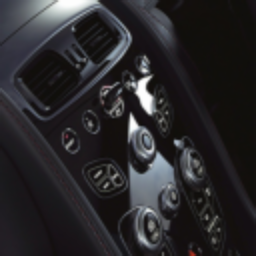

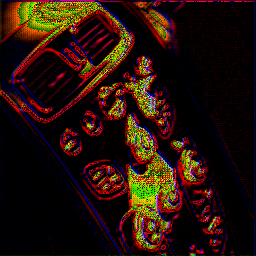

In [9]:
# display original
i = 1
im = transform.ToPILImage()(image_batch[i]).convert("RGB")
display(im)

# display reconstruction
im = transform.ToPILImage()(image_batch_recon[i]).convert("RGB")
display(im)

In [10]:
def train(model, train_loader, train_loader_hd, val_loader, val_loader_hd, Epochs, loss_fn):
    train_loss_avg = []
    val_loss_avg = []
    for epoch in range(Epochs):
        train_loss_avg.append(0)
        num_batches = 0
        iterator = iter(train_loader_hd)
        for image_batch, _ in train_loader:
            image_batch = image_batch.to(device)
            batch_list = next(iterator)
            image_batch_hd = batch_list[0].to(device)
            image_batch_recon = model(image_batch)
            loss = loss_fn(image_batch_recon, image_batch_hd)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          
            train_loss_avg[-1] += loss.item()
            num_batches += 1
        
        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
        
        iterator = iter(val_loader_hd)
        val_loss_avg.append(0)
        num_batches=0
        for image_batch, _ in val_loader:
            image_batch = image_batch.to(device)
            batch_list = next(iterator)
            image_batch_hd = batch_list[0].to(device)
            image_batch_recon = model(image_batch)
            with torch.no_grad():
                loss = loss_fn(image_batch_recon, image_batch_hd)
                val_loss_avg[-1] += loss.item()
                num_batches += 1
        val_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average reconstruction validation error: %f' % (epoch+1, Epochs, val_loss_avg[-1]))
                
    return train_loss_avg, val_loss_avg

In [11]:
capacity = 64
epochs = 10    
learning_rate = 0.0001
autoencoder = Autoencoder()
autoencoder.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-6)


loss_result, loss_val = train(autoencoder,train_loader_low, train_loader_hd, val_loader_low, val_loader_hd, epochs, loss_fn)

Epoch [1 / 10] average reconstruction error: 0.194776
Epoch [1 / 10] average reconstruction validation error: 0.141199
Epoch [2 / 10] average reconstruction error: 0.124840
Epoch [2 / 10] average reconstruction validation error: 0.115794
Epoch [3 / 10] average reconstruction error: 0.108263
Epoch [3 / 10] average reconstruction validation error: 0.103600
Epoch [4 / 10] average reconstruction error: 0.101706
Epoch [4 / 10] average reconstruction validation error: 0.099151
Epoch [5 / 10] average reconstruction error: 0.098518
Epoch [5 / 10] average reconstruction validation error: 0.096088
Epoch [6 / 10] average reconstruction error: 0.095988
Epoch [6 / 10] average reconstruction validation error: 0.094353
Epoch [7 / 10] average reconstruction error: 0.093890
Epoch [7 / 10] average reconstruction validation error: 0.091294
Epoch [8 / 10] average reconstruction error: 0.093456
Epoch [8 / 10] average reconstruction validation error: 0.091030
Epoch [9 / 10] average reconstruction error: 0.0

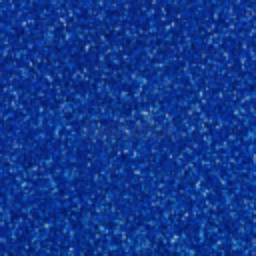

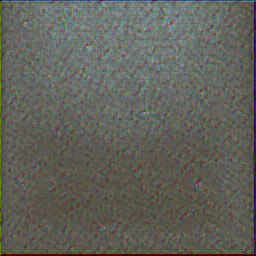

In [31]:
for image_batch, _ in train_loader_low:
  image_batch = image_batch.to(device)
  image_batch_recon = autoencoder(image_batch)
  #Show_imgs(image_batch[0].cpu(),"")
  #Show_imgs(image_batch_recon[0].cpu(),"")
  #image_batch[0].cpu() 
  im = transform.ToPILImage()(image_batch[0]).convert("RGB")  
  display(im)
  imt = transform.ToPILImage()(image_batch_recon[0]).convert("RGB")
  display(imt) 
  break